## Nottingham University Hospitals NHS Trust Overnight Bed Occupancy Rate Forecast

### Scenario

Bed occupancy rate has remained as the most important parameter to evaluate the utilisation of hospitals.
It is a management indicator that provides information on the hospital’s service capacity, helping to assess whether there are missing or empty beds and to know about the usability of the spaces. 

Why is it important?  Bed maintenance is an expensive process for the hospital, involving cleaning, disinfection, and maintenance costs. In this context, it is important to have accurate and quality information, to ensure that the investments involved are better utilized and reduced within the possible limits. As reference, a general ward cost per bed day £586.59, where an ICU cost per day is £1621.16 
(from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7045184/#R26).

From the data of Overnight Bed Availability and Occupancy Data available from the NHS Statistics website, we can obtain the data of the Nottingham University Hospitals NHS Trust from June 2010 to September 2022. With it, we can attempt to train machine learning models to predict the occupancy of the next quarter correspoinding to December 2022, and save costs by reducing expenses.


### Goal

Accurately forecast the overnight bed occupancy rate for Quarter December 2022 via Machine Learning.

### Data
https://www.england.nhs.uk/statistics/statistical-work-areas/bed-availability-and-occupancy/


#### 1.0 Load Dependencies

In [46]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
from matplotlib.pyplot import figure
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from darts import TimeSeries
from darts.models import ARIMA, Prophet
from darts.metrics import mape, mae, r2_score, rmse
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#### 1.1 Load Files and Create Dataframe

In [47]:
# set directory path
cwd = os.path.join("C:/Users/mifab/Documents/Git/NHS_interview/Data/")
files = os.listdir(cwd)  # obtain filenames
hospital_dataset = pd.DataFrame([])  # create empty dataframe to fill
# names of columns we wish to extract, as there are duplicate names
colnames = ['Year', 'Period_End', 'Available', 'Occupied']

for file in files:  # for loop
    input_file_path = os.path.join(cwd, file)  # get full file path to load
    # load an excel file in the sheet 'NHS Trust by Sector'
    temp_page = pd.read_excel(
        input_file_path, sheet_name='NHS Trust by Sector')
    # extract columns names for row 13
    temp_page.columns = temp_page.iloc[13, :]
    # drop the first 13 rows that dont have the information
    temp_page.drop(temp_page.index[0:14], inplace=True)
    # search for the nottingham university nhs trust via the organisation code 'RX1'
    temp_col = temp_page[temp_page['Org Code'] == 'RX1']
    # obtain the columns of interest 'Year', 'Period_End', 'Total Available'and ' Total Occupied'
    temp_col = temp_col.iloc[:, [1, 2, 6, 12]]
    # rename columns as 'total' is duplicate and does not allow concatenation
    temp_col.columns = colnames
    # concatenation of the next row
    hospital_dataset = pd.concat([hospital_dataset, temp_col], axis=0)

display(hospital_dataset.head())
print(hospital_dataset.shape)

,Year,Period_End,Available,Occupied
125,2019-20,June,1626.032967,1428.340659
125,2019-20,September,1607.673913,1417.934783
123,2019-20,December,1672.293478,1468.347826
123,2019-20,March,1658.978022,1431.21978
129,2018-19,June,1591.703297,1374


(50, 4)


We have obtained a Dataframe of 50 entries (4 per year since 2010 and 2 of 2022).

#### 1.2 Obtain a date-time format  and the Occupancy Rate

In [48]:
hospital_dataset['Date'] = ''  # create empty column
hospital_dataset.reset_index(drop=True, inplace=True)  # reset indexes for loop

for index, row in hospital_dataset.iterrows():  # replace year and period_end for a date format
    # for march, as it belongs to the 2d year listed
    if hospital_dataset.iloc[index, 1] == 'March':
        year = hospital_dataset.iloc[index, 0]  # select year
        year = year[:2] + year[5:]  # get the second year
        hospital_dataset.iloc[index, 4] = pd.to_datetime(
            year+'/'+hospital_dataset.iloc[index, 1])  # get date and add to column

    else:  # for all other quartes, as they belong to the first year listed
        year = hospital_dataset.iloc[index, 0]  # select year
        year = year[:4]  # get the first year
        hospital_dataset.iloc[index, 4] = pd.to_datetime(
            year+'/'+hospital_dataset.iloc[index, 1])  # get date and add to column

We now extract the Occupancy Rate and sort by the date, and after this we check if there are any empty values that need imputation.

In [49]:
# Calculate the Rate
hospital_dataset['Rate'] = hospital_dataset['Occupied'] / \
    hospital_dataset['Available']

# Extract the Date and Rate columns, sort by date
hospital_dataset_sorted = hospital_dataset[['Date', 'Rate']].sort_values(
    by=['Date'], ascending=True, ignore_index=True)

display(hospital_dataset_sorted.head(8))  # visualise the resulting matrix
display(hospital_dataset_sorted.isna().sum())  # check for NaNs

,Date,Rate
0,2010-06-01 00:00:00,0.856824
1,2010-09-01 00:00:00,0.820041
2,2010-12-01 00:00:00,0.869434
3,2011-03-01 00:00:00,0.886772
4,2011-06-01 00:00:00,0.832061
5,2011-09-01 00:00:00,0.814321
6,2011-12-01 00:00:00,0.824189
7,2012-03-01 00:00:00,0.899407


Date    0
Rate    0
dtype: int64

The Dataframe is now completed and sorted. There are no missing values that need imputation.

#### 1.3 Visualisation

Before creating a Forecast of the data, it is important to visualise it to see if there are any outliers or missing data, as well as understanding the length, amplitude, seasonality and other characteristics of the time series.

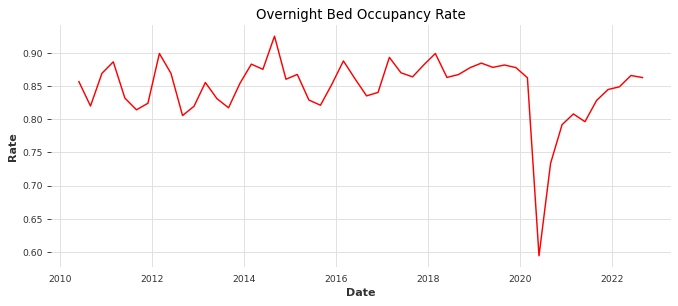

In [50]:
figure(figsize=(10, 4), dpi=80)
plt.plot(hospital_dataset_sorted['Date'],
         hospital_dataset_sorted['Rate'], color='red', label='Rate')  # plot time series
plt.xlabel('Date')  # x axis label
plt.ylabel('Rate')  # y axis label
plt.title('Overnight Bed Occupancy Rate')  # add title
plt.show()

It is common to expect a rise in occupancy in the Covid-19 times, but instead the time series shows a drop in the years 2020-21. This can be explained with the information obtained on the dataset's website:

**Note for 2020-21 data**
"Hospital capacity has had to be organised in new ways as a result of the pandemic to treat Covid and non-Covid patients separately and safely in meeting the enhanced Infection Prevention Control measures. This results in beds and staff being deployed differently from in previous years in both emergency and elective settings within the hospital. As a result, caution should be exercised in comparing overall occupancy rates between this year and previous years. In general hospitals will experience capacity pressures at lower overall occupancy rates than would previously have been the case."

With this in mind, we restric the training and validation sets of the model to be from 2010 up to Q4 of 2019.

In [51]:
split_date = datetime.strptime('02/03/2020', '%d/%m/%Y')  # set time limit
# obtain time series up to that point
data_train_val = hospital_dataset_sorted.loc[hospital_dataset_sorted.Date <= split_date].copy(
)
print(data_train_val.shape)  # count datapoints

(40, 2)


Due to the amount of datapoints available (40), we are limited in the amount of forecasting techniques to utilise.
For short univariate time series, ARIMA models can achieve goood results.
However, these models requiere that the time series is stationary, for which a series of analysis must be made before carrying it out.

#### 1.4 Evaluating Stationarity

In order to evaluate stationarity, we can run the Augmented Dickey-Fuller test, where:

-Null hypothesis: Non Stationarity exists in the series.

-Alternative Hypothesis: Stationarity exists in the series

so if we achieve a low p-value we can reject the null hypothesis and asume stationarity

In [68]:
adf_test = adfuller(data_train_val.Rate)  # run the adfuller test
print(f'p-value: {adf_test[1]}')  # print obtained p value

p-value: 0.00044500388368055134


With this p-value, we can reject the null hypothesis.
For further understanding, we can also look at the autocorrelation function plot.

<Figure size 800x800 with 0 Axes>

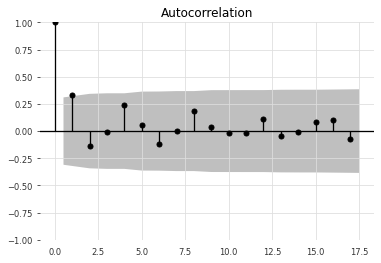

In [69]:
figure(figsize=(10, 10), dpi=80)
plot_acf(data_train_val.Rate)  # plot autocorrelation function plot
plt.show()

Where if the time series is stationary, the autocorrelation plots will show a quick drop-off in correlation after a small amount of lag between points. This confirms the obtained test results.

Another important element in time series analysis is seasonality, but it is not observed in visually or in the autocorrelation plot, as there would be a spike at lag associated with it.

#### 1.5 Split data, train the model and validate it.

First, we define a function with the evaluation metrics of the models we will use.
These are MAE, MAPE and RMSE.

In [70]:
def evaluate_forecast(y, pred):
    """summary:evaluate_forecast takes two arguements that are TimeSeries objects

    Args:
        y (TimeSeries): ground truth
        pred (TimeSeries): forecasted values

    Returns:
        results: DataFrame with three evaluation metrics
    """
    results = pd.DataFrame({
        'mean_absolute_error': mae(y, pred),},index=[0])  # add mean_absolute_error
    results['mean_absolute_percentage_error'] = mape(
        y, pred)  # add mean_absolute_percentage_error
    results['root_mean_squared_error'] = rmse(
        y, pred)  # add root_mean_squared_error
    return results

The daset is split into training and validation with a standard 80-20 split.

The former is used to fit the model and the latter to evaluate it.

In [22]:
data_train_val.set_index('Date', inplace=True)  # add date as index
# change from DataFrame to TimeSeries object for Darts models
occupancy_series = TimeSeries.from_dataframe(data_train_val)

# Split 80-20 for training-validation purposes
train, val = occupancy_series.split_before(0.8)

# create ARIMA model with default parameters for baseline
arima_model = ARIMA(p=12, d=1, q=0, seasonal_order=(
    0, 0, 0, 0), trend=None, random_state=111)
arima_model.fit(train)  # fit to training data

# predict over validation data
arima_prediction = arima_model.predict(len(val))
print('ARIMA performance:')
display(evaluate_forecast(val, arima_prediction))  # get performance scores

ARIMA performance:


,mean_absolute_error,mean_absolute_percentage_error,root_mean_squared_error
0,0.016693,1.904301,0.018286


The model is able to achieve adequate results. 

For further comparison, we will compare it to Facebook's Prophet model.

In [23]:
# create Prophet model, no seasonality or holiday
prophet_model = Prophet(add_seasonalities=None, country_holidays=None)
prophet_model.fit(train)  # fit to training data

# predict over validation data
prophet_prediction = prophet_model.predict(len(val))
print('Prophet performance:')
evaluate_forecast(val, prophet_prediction)

2022-11-27 16:05:54 prophet INFO: Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2022-11-27 16:05:54 prophet INFO: Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2022-11-27 16:05:54 prophet INFO: n_changepoints greater than number of observations. Using 23.


Prophet performance:


,mean_absolute_error,mean_absolute_percentage_error,root_mean_squared_error
0,0.015123,1.72885,0.020611


The Prophet model achieved slightly higher RMSE, but lowers MAPE and MAE.

As MAPE is the most expainable metric (average of the absolute percentage errors of forecasts), we utilise it to choose Prophet as the better model based on it.

For further analysis, we plot the validation timepoints along with the forecasts of the two models.

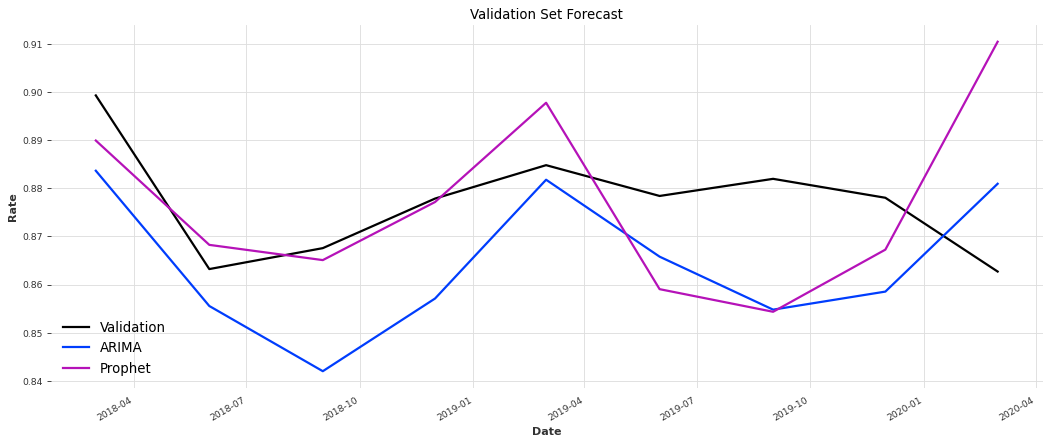

In [24]:
figure(figsize=(16, 6), dpi=80)  # create figure
val.plot(label="Validation")  # plot validation time series
arima_prediction.plot(label="ARIMA")  # plot forecasted points
prophet_prediction.plot(label="Prophet")  # plot forecasted points
plt.xlabel('Date')  # x axis label
plt.ylabel('Rate')  # y axis label
plt.title('Validation Set Forecast')  # add title
plt.legend(fontsize=12)  # add legends
plt.show()

The propher model seems to adjust better in the first third, understimate in the middle and overestimate at the end.

On the other hand, the ARIMA model underestimates across all the points.

#### 1.6 Forecast Up to Current Occupancy (Q3-December)

With these models at hand, we can forecast the occupancy up to the current date.

Furthermore will be able to observe how the model behaves during the removed 2020-21 period.

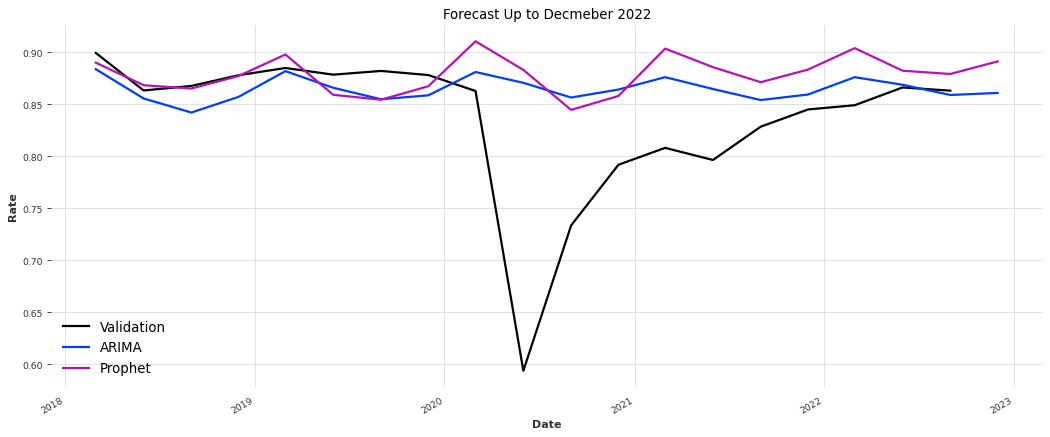

In [25]:
hospital_dataset_sorted.set_index('Date', inplace=True)  # set date as index
# create time series of the whole data
original_time_series = TimeSeries.from_dataframe(
    hospital_dataset_sorted)
# define datapoints outside training data
difference = len(original_time_series)-len(train)+1
# obtain datapoints outside training data
_, future_points = original_time_series.split_after(pd.Timestamp(2017, 12, 1))
arima_prediction = arima_model.predict(difference)  # predict up to 2023
prophet_prediction = prophet_model.predict(difference)  # predict up to 2023
figure(figsize=(16, 6), dpi=80)  # create figure
# plot time series up to december
future_points.plot(label="Validation")
# plot forecasted points up to december by ARIMA
arima_prediction.plot(label="ARIMA")
# plot forecasted points up to december by Prophet
prophet_prediction.plot(label="Prophet")
plt.xlabel('Date')  # x axis label
plt.ylabel('Rate')  # y axis label
plt.title('Forecast Up to Decmeber 2022')  # add title
plt.legend(fontsize=12)  # add legends
plt.show()

From the plot we can observe that neitheor model could have predicted the change in 2020.

Overall, the ARIMA forecast has low variance and appears to underestimate the occupancy before 2020.

On the other hand, the Prophet model starts off as accurate but overestimates over time.

This is observed in 2022, where values seem to have returned to pre-Covid-19 times.

In regards to the last reported value overernight bed occupancy (0.8630%), corresponding Q2 of 2022 (September), each model predicts the following:

In [26]:
# obtain next Q change in occupancy by arima
arima_diff = arima_prediction.values()[-1]-future_points.values()[-1]
# obtain next Q change in occupancy by prophet
prophet_diff = prophet_prediction.values()[-1]-future_points.values()[-1]

# Describe changes
print(f"""For the Q3 of 2022: \n
The ARIMA model predicts a decrease of bed occupancy of {arima_diff[0]:.4f} in regards to Q2.\n
The Prophet model predicts an increase of bed occupancy of {prophet_diff[0]:.4f} in regards to Q2.""")

For the Q3 of 2022: 

The ARIMA model predicts a decrease of bed occupancy of -0.0022 in regards to Q2.

The Prophet model predicts an increase of bed occupancy of 0.0281 in regards to Q2.


### Conclusion

We were able to forecast the overnight bed occupancy with machine learning.

The best model, Prophet, achieved a MAPE value of 1.72885.

The model can be improved with information such as the day-only beds reports, information of occupancy of nearing hospitals in the Midlands area (if a hospital is full patients will be fererred and transfered), seasonal epidemiologic information and others. With these complementary sources,  more complex models for multivariate-time series can be used.

If the reports of the daily, weekly or monthly occupancy were available, there would be more data points to train models and thus obtain better results. With a more robust model, it could be used by other NHS-listed Hospitals to forecast their own overnight bed occupancy.

In the future, it could incorporate routines that deal with possible NaNs, Outliers, zeros and other possible distortions in the dataset.

In [45]:
!pipreqsnb --force "C:/Users/mifab/Documents/Git/NHS_interview/"

Exception occurred while working on file C:\Users\mifab\Documents\Git\NHS_interview\Nottingham University Hospitals NHS Trust Overnight Bed Occupancy.ipynb, cell 41/45

Traceback (most recent call last):
  File "C:\Users\mifab\anaconda3\envs\tf-gpu\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\mifab\anaconda3\envs\tf-gpu\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\mifab\anaconda3\envs\tf-gpu\Scripts\pipreqsnb.exe\__main__.py", line 7, in <module>
  File "C:\Users\mifab\anaconda3\envs\tf-gpu\lib\site-packages\pipreqsnb\pipreqsnb.py", line 130, in main
    raise e
  File "C:\Users\mifab\anaconda3\envs\tf-gpu\lib\site-packages\pipreqsnb\pipreqsnb.py", line 126, in main
    imports += get_import_string_from_source(source)
  File "C:\Users\mifab\anaconda3\envs\tf-gpu\lib\site-packages\pipreqsnb\pipreqsnb.py", line 26, in get_import_string_from_source
    tree = ast.parse(source)
  File "C:\Users\mifab\anaconda3\envs\tf-gpu\lib\ast.py", line 50, in parse
    return compile(source, filename, mode, flags,
  File "<unknown>", line 1
    tscv.split(a)
Indenta